# Filtros de suavização

### Definindo novamente as funções de correlação e convolução

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def correlation(img, w):
    '''Calcula a correlação cruzada entre a imagem img e o filtro w.
    
       Parâmetros
       ----------
       img : numpy array.
           Imagem a ser filtrada.
       w : numpy array.
           Filtro a ser utilizada na correlação cruzada.
       
       Return
       -------
       img_filtered : numpy array, mesmo tamanho que img
           Imagem filtrada
    '''

    numRows, numCols = img.shape
    fNumRows, fNumCols = w.shape   # fNumRows=a+1 e fNumCols=b+1 (a e b da fórmula acima)

    halfRSize = fNumRows//2        # O operador // retorna a parte inteira da divisão
    halfCSize = fNumCols//2

    imgPadded = np.zeros((numRows+fNumRows-1, numCols+fNumCols-1), dtype=img.dtype)
    for row in range(numRows):
        for col in range(numCols):   
            imgPadded[row+halfRSize, col+halfCSize] = img[row, col]
    # A estrutura for aninhada acima pode ser substituída por
    #imgPadded = np.pad(img, ((halfRSize,halfRSize),(halfCSize,halfCSize)), mode='constant')
    
    img_filtered = np.zeros((numRows, numCols))
    for row in range(numRows):
        for col in range(numCols):
            sum_region = 0
            for s in range(fNumRows):
                for t in range(fNumCols):
                    # O índice do array na soma abaixo é diferente do utilizado na fórmula da 
                    # correlação porque estamos utilizando a imagem preenchida com zeros. O 
                    # pixel (0,0)  na imagem preenchida corresponde ao pixel (x+s-a/2, y+t-b/2) 
                    # da imagem original
                    sum_region += w[s, t]*imgPadded[row+s, col+t]
            img_filtered[row, col] = sum_region

            # O loop aninhado acima pode ser substituído por
            # patch = imgPadded[row:row+fNumRows, col:col+fNumCols]
            # img_filtered[row, col] = np.sum(w*patch)
            
    return img_filtered

def convolution(img, w):
    '''Calcula a convolução entre a imagem img e o filtro w.
    
       Parâmetros
       ----------
       img : numpy array.
           Imagem a ser filtrada.
       w : numpy array.
           Filtro a ser utilizada na correlação cruzada.
       
       Return
       -------
       img_filtered : numpy array, mesmo tamanho que img
           Imagem filtrada
    '''
    # Inverte o filtro
    w_inv = w[::-1, ::-1]

    img_filtered = correlation(img, w_inv)

    return img_filtered

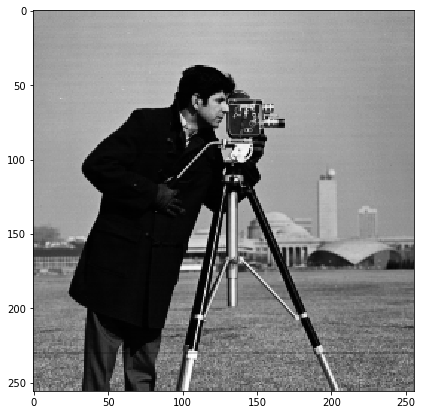

In [4]:
img = plt.imread('cameraman.tiff')
plt.figure(figsize=[7,7])
plt.imshow(img, 'gray')

# Filtro de média simples

Na imagme resultante, observe as diversas "linhas" que aparecem na imagem

In [5]:
# Cria filtro de média simples com tamanho S
S = 5
w = np.full([S,S], 1./S**2)
print(w)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


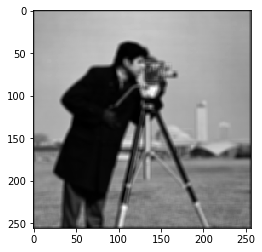

In [6]:
img_smoothed = convolution(img, w)
plt.imshow(img_smoothed, 'gray')

# Filtro de suavização gaussiana

Lembrando que a função gaussiana é definida pela equação
\begin{equation}
y(x) = \frac{1}{\sigma\sqrt{2\pi}}exp\left({-\frac{(x-\mu)^2}{2\sigma^2}}\right)
\end{equation}
onde $\mu$ é o ponto central da função. Consideraremos que $\mu=0$

## 1. Visualização da função gaussiana

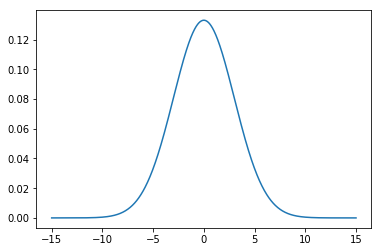

In [7]:
sigma = 3
x = np.linspace(-5*sigma, 5*sigma, 1000)
y = np.exp(-x**2/(2*sigma**2))
y = y/(sigma*np.sqrt(2*np.pi))
plt.plot(x, y)

## 2. Filtro gaussiano em uma dimensão

In [8]:
def gaussian_filter_1d(filter_size):
    sigma = filter_size/6.
    x = np.linspace(-3*sigma, 3*sigma, filter_size)
    y = np.exp(-x**2/(2*sigma**2))
    
    # Filtros de suavização precisam ter soma igual a 1
    y = y/np.sum(y)

    return y

y = gaussian_filter_1d(5)
print(y)

[0.00664603 0.19422555 0.59825683 0.19422555 0.00664603]


In [9]:
# Sinal 1D simples, representado como uma matriz de uma única linha
signal = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0]])
# O filtro gaussiano definido acima é um array 1D, como nossa função de convolução
# espera um array 2D, redimensionamos o filtro para um array 2D de uma linha
w = y.reshape(1, len(y))
filtered_signal = convolution(signal, w)
print('Sinal filtrado: ')
print(filtered_signal)

Sinal filtrado: 
[[0.         0.         0.00664603 0.19422555 0.59825683 0.19422555
  0.00664603 0.         0.        ]]


Note que o sinal filtrado possui exatamente os valores do filtro utilizado. Isso porque o sinal é um impulso (valor 1 cercado de zeros). Dessa forma, podemos interpretar a suavização da seguinte forma: o valor 1 do sinal é "espalhado" (difundido) ao longo da sua vizinhança.

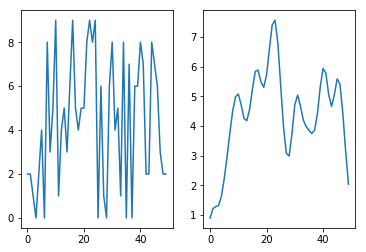

In [10]:
# Sinal 1D aleatório
S = 10
signal = np.random.randint(0, 10, size=(1, 50))
w = gaussian_filter_1d(S).reshape(1, S)
filtered_signal = convolution(signal, w)
plt.subplot(1, 2, 1)
plt.plot(signal[0])
plt.subplot(1, 2, 2)
plt.plot(filtered_signal[0])

Text(0.5,1,'Sinal filtrado')

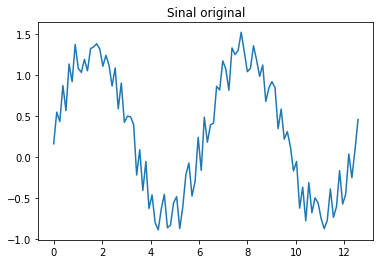

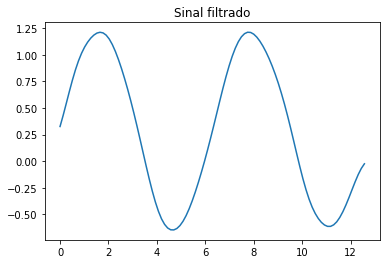

In [11]:
# Filtragem de uma função seno ruidosa
# Cria função seno com um pouco de ruído
x = np.linspace(0, 4*np.pi, 100)
corrupted_sin = np.sin(x) + 0.6*np.random.rand(len(x))
plt.plot(x, corrupted_sin)
plt.title('Sinal original')

# Filtra sinal
S = 21
w = gaussian_filter_1d(S).reshape(1, S)
corrupted_sin = corrupted_sin.reshape(1, len(corrupted_sin))
filtered_signal = convolution(corrupted_sin, w)
plt.figure()
plt.plot(x, filtered_signal[0])
plt.title('Sinal filtrado')

## 3. Filtro gaussiano bidimensional

Função gaussiana em duas dimensões:

\begin{equation}
z(x) = \frac{1}{2\pi\sigma^2}exp\left({-\frac{(x-\mu_x)^2 + (y-\mu_y)^2}{2\sigma^2}}\right)
\end{equation}
onde $\mu_x$ e $\mu_y$ indicam o ponto central da função em $x$ e $y$. Consideraremos que o centro da função é a origem ($\mu_x=0$ e $\mu_y=0$).

In [12]:
def gaussian_filter_2d(filter_size):
    sigma = filter_size/6.
    x_vals = np.linspace(-3*sigma, 3*sigma, filter_size)
    y_vals = x_vals.copy()
    z = np.zeros((filter_size, filter_size))
    for row in range(filter_size):
        x = x_vals[row]
        for col in range(filter_size):
            y = y_vals[col]
            z[row, col] = np.exp(-(x**2+y**2)/(2*sigma**2))
    z = z/np.sum(z)

    return z

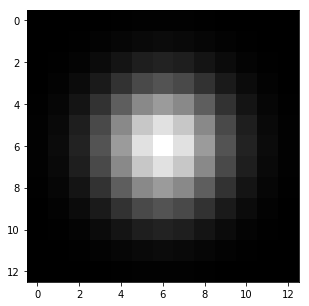

In [13]:
w = gaussian_filter_2d(13)
plt.figure(figsize=[5,5])
plt.imshow(w, 'gray')

In [14]:
img = plt.imread('cameraman.tiff')
img_filtered = convolution(img, w)

Text(0.5,1,'Filtered')

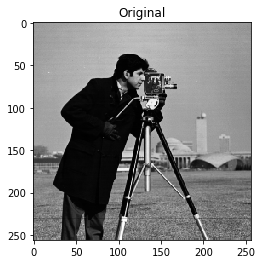

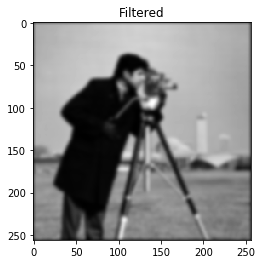

In [15]:
plt.figure()
plt.imshow(img, 'gray')
plt.title('Original')
plt.figure()
plt.imshow(img_filtered, 'gray')
plt.title('Filtered')

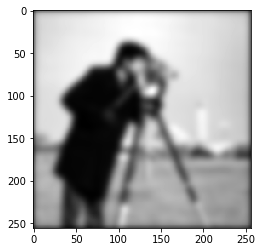

In [16]:
# Filtragem utilizando uma função do scipy
import scipy.signal
w = gaussian_filter_2d(25)
img_filtered_scipy = scipy.signal.convolve(img, w, mode='same')
plt.imshow(img_filtered_scipy, 'gray')

## Usando suavização para segmentar um objeto

#### Note que a imagem abaixo está muito ruidosa, e com isso não há como tornarmos a imagem binária utilizando uma transformação de limiarização.

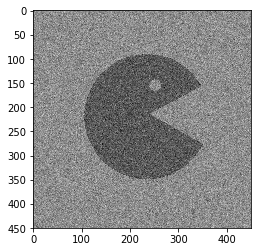

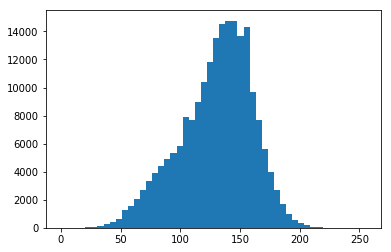

In [17]:
pacman = plt.imread('pacman.tiff')
plt.imshow(pacman, 'gray')
plt.figure()
_ = plt.hist(pacman.flatten(), 50)

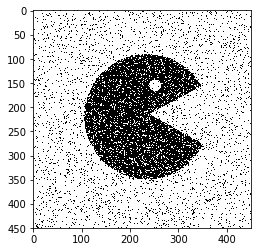

In [18]:
pacman_thresholded = pacman>110
plt.imshow(pacman_thresholded, 'gray')

#### Ao suavizarmos a imagem, o histograma (mostrado abaixo) passa a apresentar dois picos característicos. O pico à esquerda corresponde ao objeto, enquanto que o pico à direita corresponde ao fundo da imagem. Portanto, um limiar apropriado para a imagem é um valor entre os dois picos.

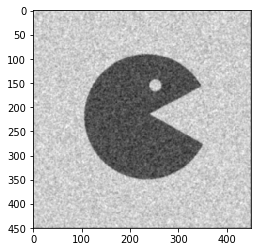

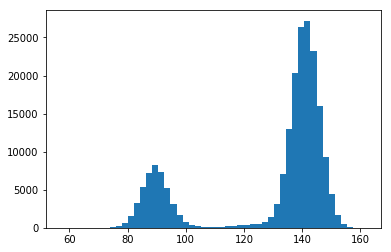

In [19]:
import scipy.ndimage as ndi
w = gaussian_filter_2d(9)
pacman_filtered = scipy.signal.convolve(pacman, w, mode='same')
plt.imshow(pacman_filtered, 'gray')
plt.figure()
_ = plt.hist(pacman_filtered.flatten(), 50)

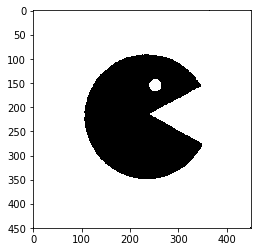

In [20]:
pacman_filt_thresholded = pacman_filtered>110
plt.imshow(pacman_filt_thresholded, 'gray')